# Samuel Watkins, 3032132676

# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## 1. Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [1]:
from skimage.data import coins
from skimage.exposure import equalize_adapthist
from skimage.filters import threshold_otsu, threshold_triangle
from skimage.segmentation import clear_border
from skimage.morphology import closing, binary_opening, binary_closing,remove_small_objects,disk,reconstruction
from skimage.measure import regionprops, label, find_contours, ransac, EllipseModel
from skimage.color import label2rgb
from skimage.draw import ellipse_perimeter
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
import numpy as np

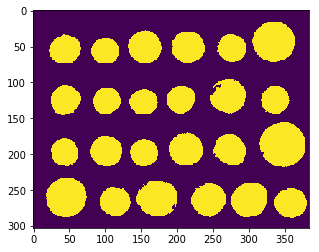

In [90]:
coins_eq = equalize_adapthist(coins())
coins_thresh = threshold_otsu(coins_eq)
coins_binary = coins_eq > coins_thresh
coins_borderless = clear_border(coins_binary)
coins_closed = closing(coins_borderless)
coin_props = regionprops(label(coins_closed))

region_sizes=np.array([prop["area"] for prop in coin_props])
size_thresh = threshold_otsu(region_sizes)
coins_largeobjs = remove_small_objects(coins_closed,min_size=size_thresh)
                                       
structure_el = disk(1)
seed = np.copy(coins_largeobjs)
seed[1:-1, 1:-1] = coins_largeobjs.max()
mask = coins_largeobjs
coins_noholes = reconstruction(seed, mask, selem=structure_el, method='erosion')

coin_props = regionprops(label(coins_noholes))
region_sizes=np.array([prop["area"] for prop in coin_props])
size_thresh= threshold_triangle(region_sizes)
coins_noholes = remove_small_objects(coins_noholes.astype("bool"),min_size=size_thresh)

plt.imshow(coins_noholes)

contours = find_contours(coins_noholes,0)

coins_edges = np.zeros_like(coins_noholes,dtype=bool)
for contour in contours:
    for point in contour.astype("int"):
        coins_edges[point[0],point[1]] = True

coin_edges_props = regionprops(label(coins_edges))

bbox = np.array([prop["bbox"] for prop in coin_edges_props]).astype("int")

drawn_ellipses = np.zeros_like(coins_edges,dtype=bool)
eccentricities = np.zeros(len(coin_edges_props))
areas = np.zeros(len(coin_edges_props))

# for ii,prop in enumerate(coin_edges_props):
#     x,y = np.where(prop["image"])
#     points = np.vstack([x,y]).transpose()
#     model_robust, inliers = ransac(points,EllipseModel,3,10)
#     xc, yc, a, b, theta = model_robust.params
#     absolute_coords = np.array([bbox[ii,0],bbox[ii,1]])
#     cy, cx = ellipse_perimeter(int(yc+absolute_coords[0]), int(xc+absolute_coords[1]), int(a), int(b), theta)
#     drawn_ellipses[cy,cx] = True
#     areas[ii] = np.pi*a*b
#     if b<a:
#         eccentricities[ii] = np.sqrt(1.0-b**2/a**2)
#     else:
#         eccentricities[ii] = np.sqrt(1.0-a**2/b**2)

for ii,contour in enumerate(contours):
    model_robust, inliers = ransac(contour[:,::-1],EllipseModel,4,2)
    xc, yc, a, b, theta = model_robust.params
    cy, cx = ellipse_perimeter(int(yc), int(xc), int(a), int(b),orientation=theta-np.pi/2)
    drawn_ellipses[cy,cx] = True
    areas[ii] = np.pi*a*b
    if b<a:
        eccentricities[ii] = np.sqrt(1.0-b**2/a**2)
    else:
        eccentricities[ii] = np.sqrt(1.0-a**2/b**2)

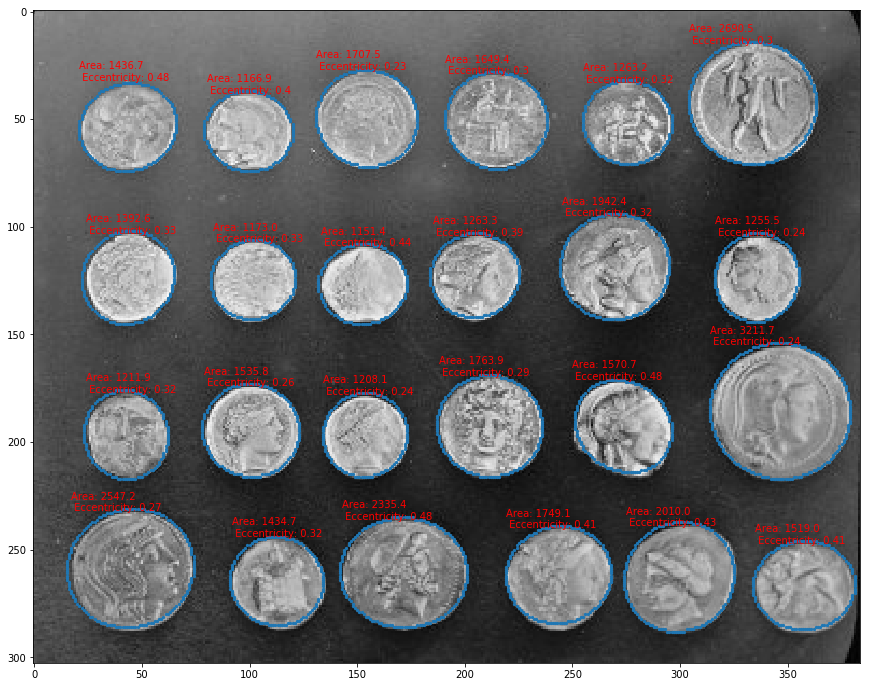

In [93]:
fig,ax = plt.subplots(figsize=(20,12))
ax.imshow(coins(),cmap="gray")
x,y = np.where(drawn_ellipses)
ax.scatter(y,x,s=5)
# x,y = np.where(coins_edges)
# ax.scatter(y,x,s=5)
# segment_centers = np.array([prop["centroid"]])

for ii,coords in enumerate(bbox):
    ax.annotate(f'Area: {round(areas[ii],1)}\n Eccentricity: {round(eccentricities[ii],2)}',
                xy =[0,0], xytext=(coords[1], coords[0]),color="red")

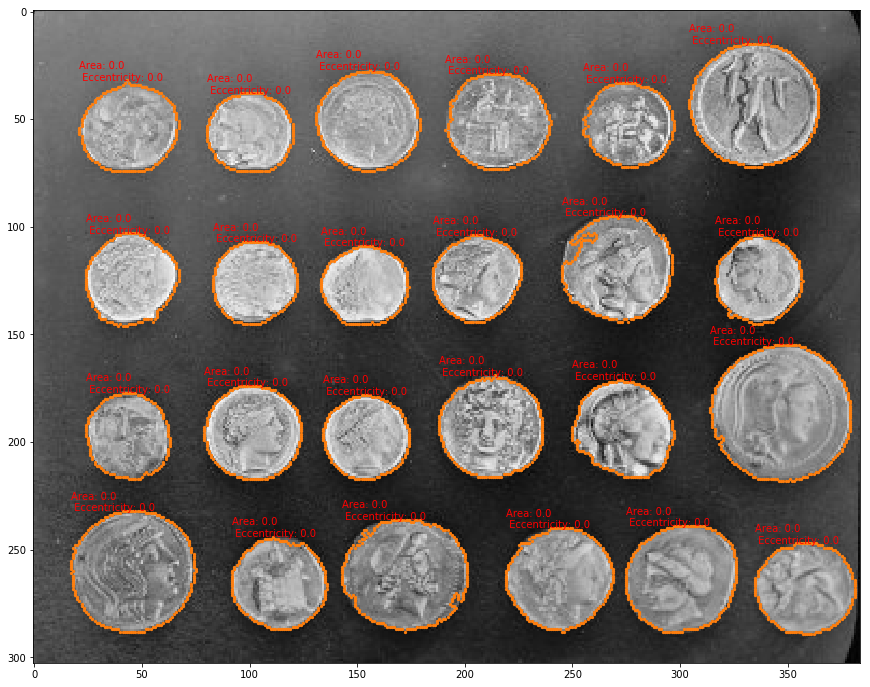

In [82]:
fig,ax = plt.subplots(figsize=(20,12))
ax.imshow(coins(),cmap="gray")
x,y = np.where(drawn_ellipses)
ax.scatter(y,x,s=5)
x,y = np.where(coins_edges)
ax.scatter(y,x,s=5)
# segment_centers = np.array([prop["centroid"]])

for ii,coords in enumerate(bbox):
    ax.annotate(f'Area: {round(areas[ii],1)}\n Eccentricity: {round(eccentricities[ii],2)}',
                xy =[0,0], xytext=(coords[1], coords[0]),color="red")

## 2. Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

In [89]:
theta * 180/np.pi

-1.3081573492976322

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.